# MAE 598 Project1
#  SIDA XUE
# ID number:1222610467






## Problem Formulation
Expanding from the problem formulating in the project demo code, the other factors we consider are:
- drag force exerted on rocket
- experimenting with rocket landing with different height
- noise in the state(position and velocity) 

In the second part of the formulation, we consider:
- horizontal thrust on the rocket
The rocket still land vertically on the platform in the following problem formulation. 

## 1. consider drag, rocket landing from various height and noise in the state

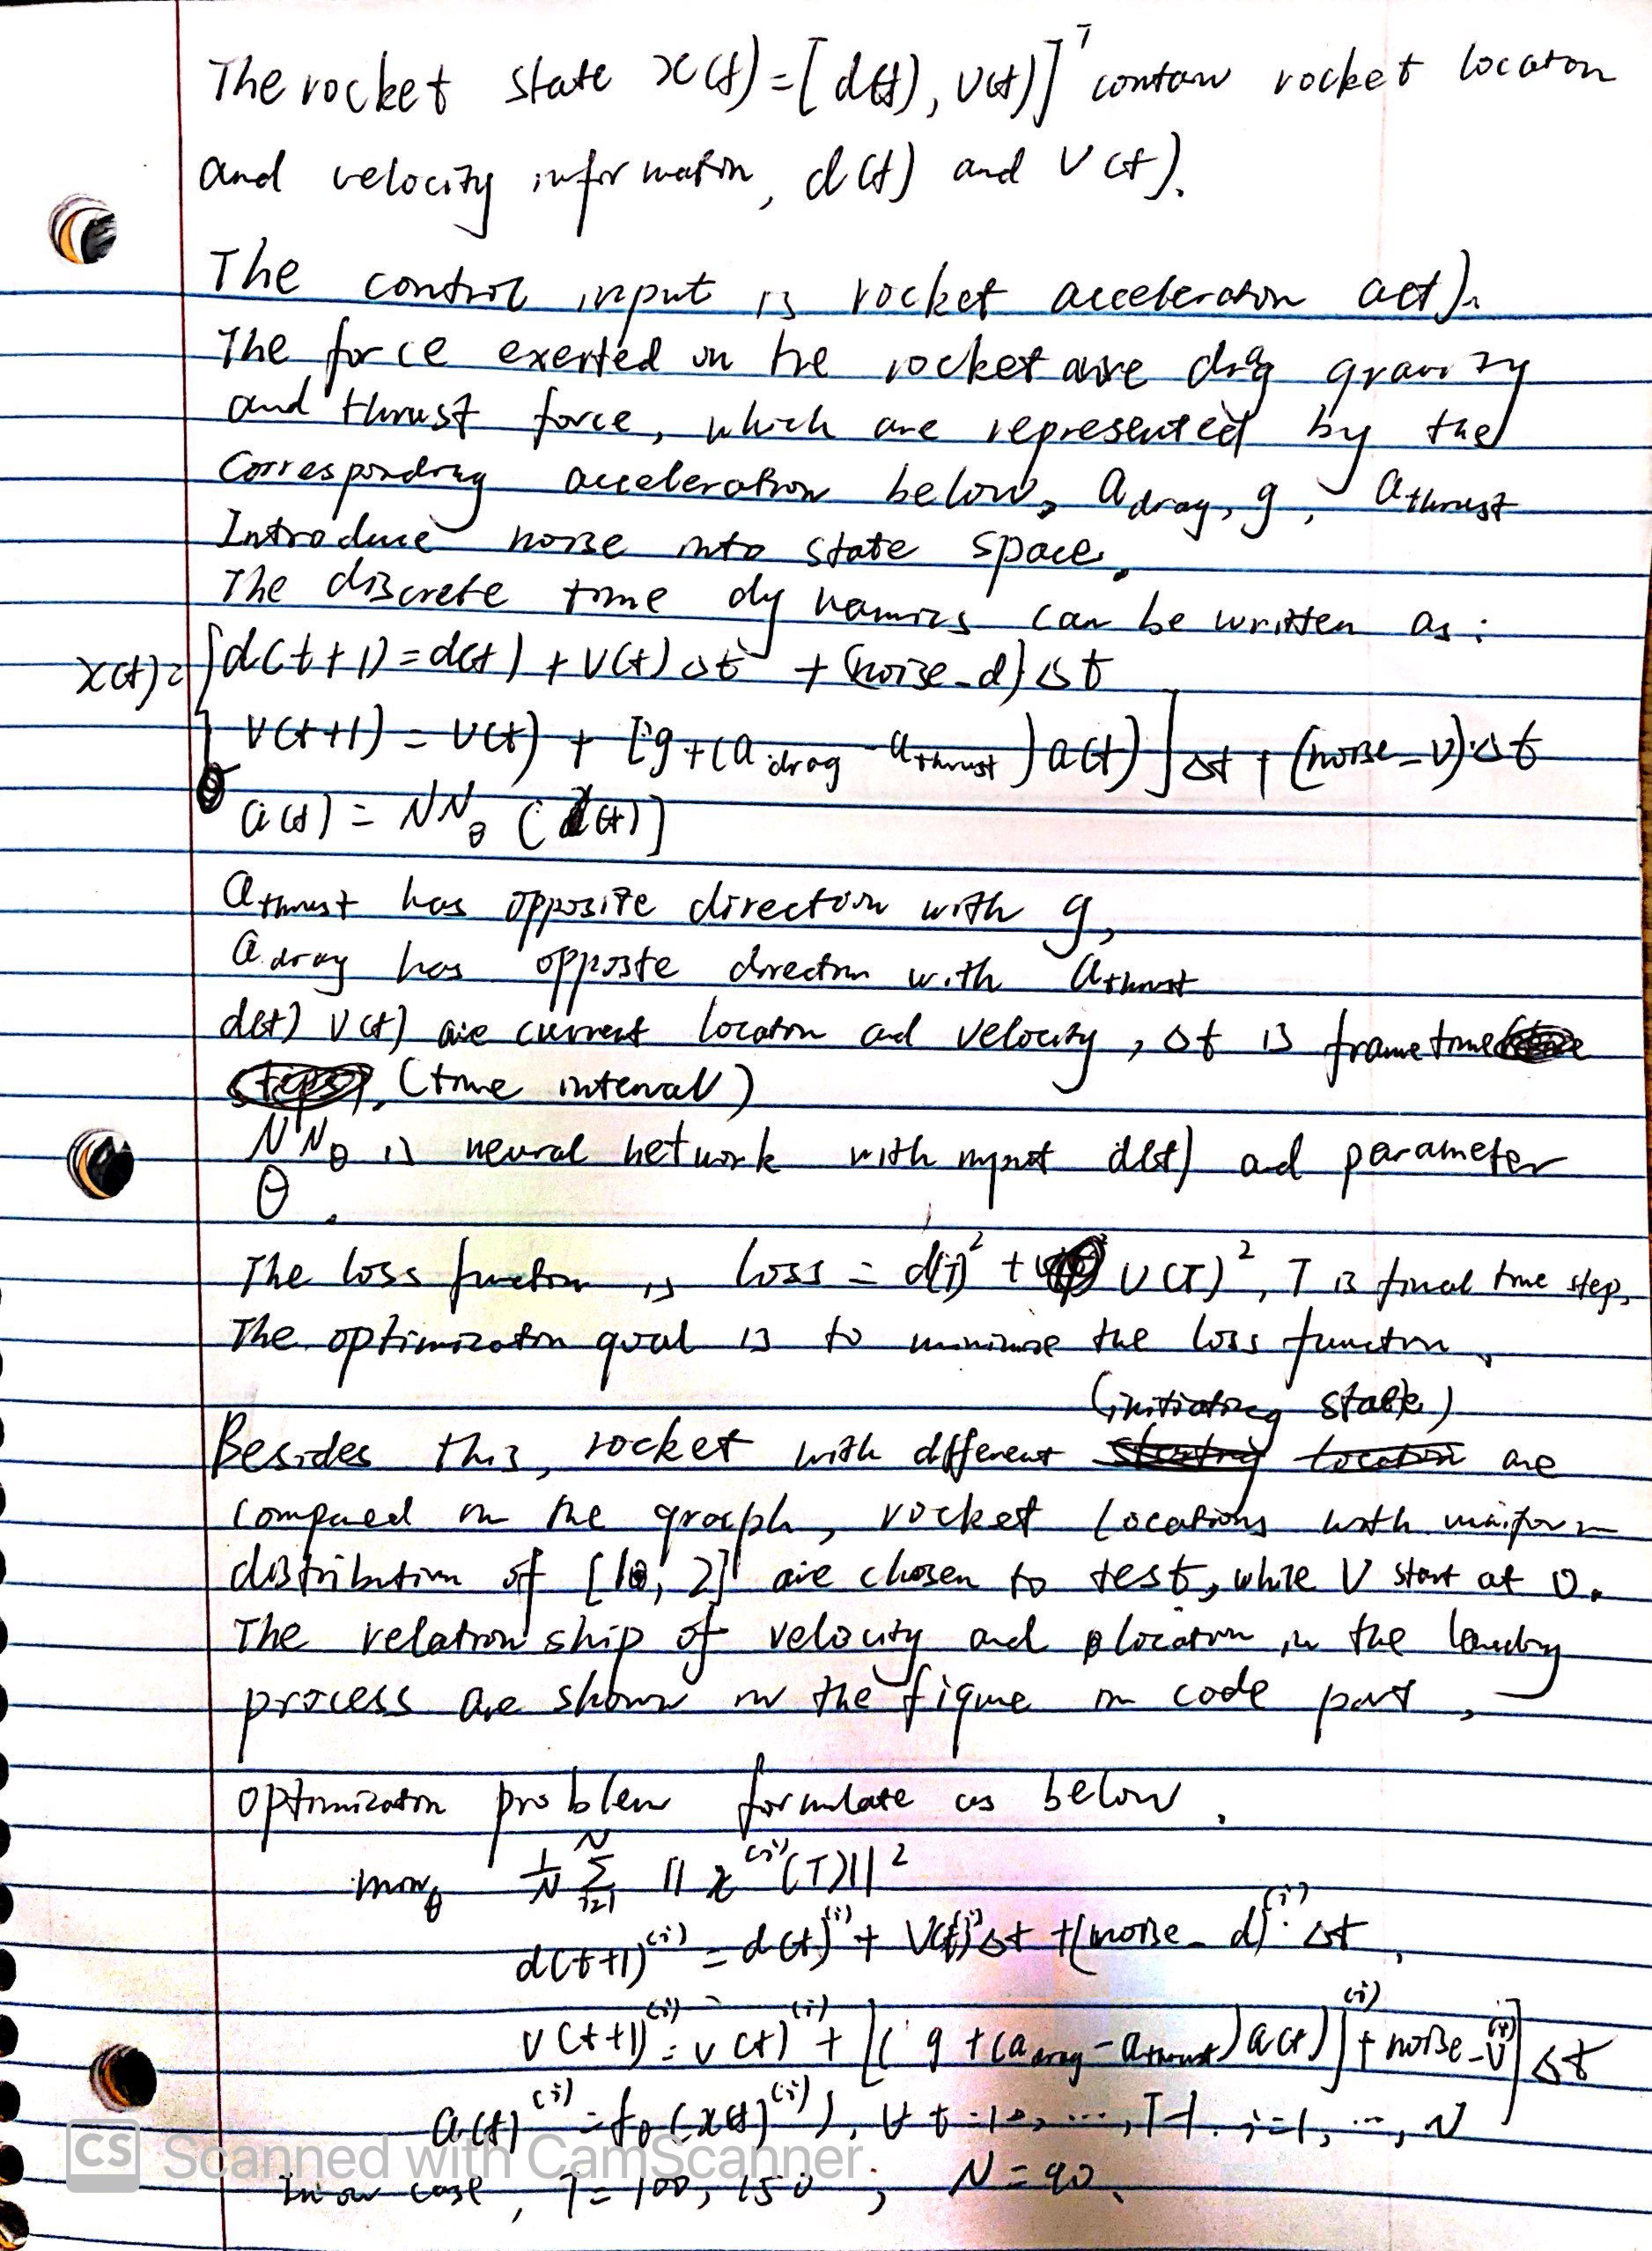

In [150]:
import logging
import numpy as np
import torch as t
import torch.nn as nn
from torch import optim
import matplotlib.pyplot as plt

logger = logging.getLogger(__name__)

# environment parameters
ROTATION_ACCEL = 20  # rotation constant
PLATFORM_WIDTH = 0.25  # landing platform width
PLATFORM_HEIGHT = 0.06  # landing platform height
FRAME_TIME = 0.1  # time interval
GRAVITY_ACCEL = 0.12  # gravity constant
BOOST_ACCEL = 0.18  # thrust constant
DRAG_ACCEL = 0.003  # drag constant

class Controller(nn.Module):  ## no need to change the controller because the problem formulated here is quite easy to 
    ##solve

    def __init__(self, dim_input, dim_hidden, dim_output):
        """
        dim_input: # of system states
        dim_output: # of actions
        dim_hidden: # up to you
        """
        super(Controller, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(dim_input, dim_hidden),
            nn.Tanh(),
            nn.Linear(dim_hidden, dim_output),
            nn.Sigmoid())

    def forward(self, state):
        action = self.network(state)
        return action

class Dynamics(nn.Module):

    def __init__(self):
        super(Dynamics, self).__init__()

    def forward(self, state, action,  low_b_noise, up_b_noise): ## introduce noise in state
        """
        action: thrust or not thrust
        state[0] = y
        state[1] = y_dot
        
        """
        # Apply gravity
        delta_state_gravity = t.tensor([0., (GRAVITY_ACCEL) * FRAME_TIME])

        # Thrust
        delta_state_thrust = (- BOOST_ACCEL) * FRAME_TIME * t.tensor([0., 1.]) * action
        
        #Apply drag. Drag acceleration has opposite direction compared to thrust acceleration
        delta_state_drag = (DRAG_ACCEL) * FRAME_TIME * t.tensor([0., 1.]) * action
        # noise in d and v
        noise_d = t.tensor([1, 0]) * t.tensor(np.random.uniform(low_b_noise, up_b_noise,1))
        noise_v = t.tensor([0, 1]) * t.tensor(np.random.uniform(low_b_noise, up_b_noise,1))
         
        noise = noise_d+noise_v

        # Update velocity
        state = state + delta_state_thrust + delta_state_gravity + delta_state_drag

        # Update state
        step_mat = t.tensor([[1., 0.],
                             [FRAME_TIME, 1.]])
      
        state = t.matmul(state, step_mat) + noise.float()*FRAME_TIME
      
        return state
    
class Simulation(nn.Module):

    def __init__(self, controller, dynamics, T,  low_b_noise, up_b_noise):
        super(Simulation, self).__init__()
        self.state = self.initialize_state()
        self.controller = controller
        self.dynamics = dynamics
        self.T = T
        self.action_trajectory = []
        self.state_trajectory = []
        self.low_b_noise = low_b_noise
        self.up_b_noise = up_b_noise

    def forward(self, state):
        self.action_trajectory = []
        self.state_trajectory = []
        for _ in range(T):
            action = self.controller.forward(state)
            state = self.dynamics.forward(state, action,  self.low_b_noise, self.up_b_noise)
            self.action_trajectory.append(action)
            self.state_trajectory.append(state)
        return self.error(state)

    @staticmethod
    def initialize_state():        
        state = np.zeros((40, 2))## test with 40 different starting position
        for i in range(state.shape[0]):
            state[i][0] = np.random.uniform(1, 2)
            state[i][1] = 0
          
        return t.tensor(state, requires_grad=False).float()

    def error(self, state):  ##loss function
        return t.mean(state ** 2)

class Optimize:

    def __init__(self, simulation):
        self.simulation = simulation
        self.parameters = simulation.controller.parameters()
        self.optimizer = optim.LBFGS(self.parameters, lr=0.01)
        print()

    def step(self):
        def closure():
            loss = self.simulation(self.simulation.state)
            self.optimizer.zero_grad()
            loss.backward()
            return loss

        self.optimizer.step(closure)
        return closure()

    def train(self, epochs):
        for epoch in range(epochs):
            loss = self.step()
            print('[%d] loss: %.3f' % (epoch + 1, loss))
        self.visualize()

    def visualize(self):
        data = np.array([[self.simulation.state_trajectory[i][j].detach().numpy() for i in range(self.simulation.T)] for j in range(40)])
        for i in range(40):
            x = data[i, :, 0]
            y = data[i, :, 1]
            plt.plot(x, y)
        plt.title('position of the rocket VS velocity of the rocket')
        plt.xlabel('Rocket Position')
        plt.ylabel('Rocket Velocity')
        plt.show()

# Run the code and discuss
The time step is set to be 150. and state space dimension is 2, action space dimension is 1. introduce a noise with uniform distribution in (-1e-5,1e-5).  In the figure, the relationship of rocket velocity and location are shown. 40 different rocket starting height(initiating location) are chosen. 


[1] loss: 10.657
[2] loss: 5.638
[3] loss: 3.277
[4] loss: 1.811
[5] loss: 1.001
[6] loss: 0.574
[7] loss: 0.337
[8] loss: 0.205
[9] loss: 0.130
[10] loss: 0.087
[11] loss: 0.061
[12] loss: 0.045
[13] loss: 0.034
[14] loss: 0.025
[15] loss: 0.018
[16] loss: 0.015
[17] loss: 0.014
[18] loss: 0.013
[19] loss: 0.013
[20] loss: 0.012
[21] loss: 0.012
[22] loss: 0.012
[23] loss: 0.012
[24] loss: 0.012
[25] loss: 0.009
[26] loss: 0.005
[27] loss: 0.003
[28] loss: 0.002
[29] loss: 0.001
[30] loss: 0.001
[31] loss: 0.001
[32] loss: 0.000
[33] loss: 0.000
[34] loss: 0.000
[35] loss: 0.000
[36] loss: 0.000
[37] loss: 0.000
[38] loss: 0.000
[39] loss: 0.000
[40] loss: 0.000


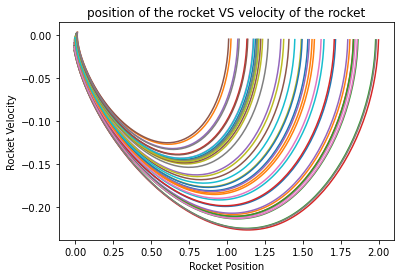

In [151]:
T = 150 # time steps
dim_input = 2  # state space dimensions
dim_hidden = 6  # latent dimensions
dim_output = 1  # action space dimensions
low_b_noise, up_b_noise = (-1e-5, 1e-5)
d = Dynamics()  # define dynamics
c = Controller(dim_input, dim_hidden, dim_output)  # control input, created by neural networks
s = Simulation(c, d, T,  low_b_noise, up_b_noise)  #simulation define the controller,dynamics,time steps and noise boundary 
o = Optimize(s)  # optimizer
o.train(40)


[1] loss: 2.749
[2] loss: 1.489
[3] loss: 0.950
[4] loss: 0.647
[5] loss: 0.455
[6] loss: 0.325
[7] loss: 0.235
[8] loss: 0.171
[9] loss: 0.125
[10] loss: 0.094
[11] loss: 0.073
[12] loss: 0.061
[13] loss: 0.053
[14] loss: 0.048
[15] loss: 0.044
[16] loss: 0.040
[17] loss: 0.035
[18] loss: 0.028
[19] loss: 0.020
[20] loss: 0.015
[21] loss: 0.010
[22] loss: 0.006
[23] loss: 0.004
[24] loss: 0.003
[25] loss: 0.003
[26] loss: 0.002
[27] loss: 0.002
[28] loss: 0.001
[29] loss: 0.001
[30] loss: 0.001
[31] loss: 0.001
[32] loss: 0.001
[33] loss: 0.000
[34] loss: 0.000
[35] loss: 0.000
[36] loss: 0.000
[37] loss: 0.000
[38] loss: 0.000
[39] loss: 0.000
[40] loss: 0.000


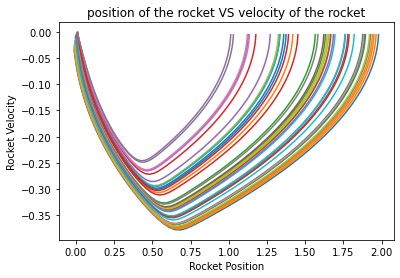

In [152]:
T = 100 # time steps
dim_input = 2  # state space dimensions
dim_hidden = 6  # latent dimensions
dim_output = 1  # action space dimensions
low_b_noise, up_b_noise = (-1e-5, 1e-5)
d = Dynamics()  # define dynamics
c = Controller(dim_input, dim_hidden, dim_output)  # control input, created by neural networks
s = Simulation(c, d, T,  low_b_noise, up_b_noise)  #simulation define the controller,dynamics,time steps and noise boundary 
o = Optimize(s)  # optimizer
o.train(40)

## noise 1e-3, time steps=100
As can be seen in the figure, as the noise become larger, the convergence to the expected space state is slower, we can see the v-d curve with not smooth path. 


[1] loss: 3.961
[2] loss: 1.885
[3] loss: 1.735
[4] loss: 1.441
[5] loss: 1.566
[6] loss: 1.380
[7] loss: 0.467
[8] loss: 0.414
[9] loss: 0.463
[10] loss: 0.424
[11] loss: 0.412
[12] loss: 0.442
[13] loss: 0.443
[14] loss: 0.614
[15] loss: 0.620
[16] loss: 0.621
[17] loss: 0.599
[18] loss: 0.617
[19] loss: 0.613
[20] loss: 0.632
[21] loss: 0.598
[22] loss: 0.205
[23] loss: 0.178
[24] loss: 0.111
[25] loss: 0.111
[26] loss: 0.128
[27] loss: 0.129
[28] loss: 0.112
[29] loss: 0.106
[30] loss: 0.137
[31] loss: 0.114
[32] loss: 0.138
[33] loss: 0.119
[34] loss: 0.123
[35] loss: 0.133
[36] loss: 0.123
[37] loss: 0.118
[38] loss: 0.151
[39] loss: 0.093
[40] loss: 0.130


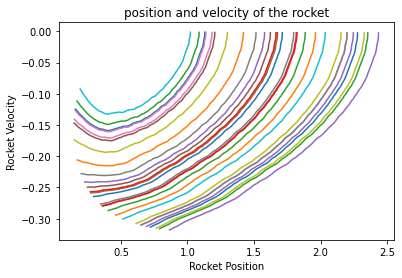

In [120]:
T = 100 # time steps
dim_input = 2  # state space dimensions
dim_hidden = 6  # latent dimensions
dim_output = 1  # action space dimensions
low_b_noise, up_b_noise = (-1e-3, 1e-3)
d = Dynamics()  # define dynamics
c = Controller(dim_input, dim_hidden, dim_output)  # control input, created by neural networks
s = Simulation(c, d, T,  low_b_noise, up_b_noise)  #simulation define the controller,dynamics,time steps and noise boundary 
o = Optimize(s)  # optimizer
o.train(40)

## noise 1e-3, with larger time steps. time steps=200
Next, we increase the time steps of the simulations, but maintain the noise at the (-1e-3,1e-3) level. This time we can see that the final state of the rocket is much closer to the state value we expected. For rocket starting at 1m aove the platform, the velocity and the distance are -0.06m/s and 0.25m above the platform. 
It indicates that as long as the time steps are adequate enough, the controller will push the rocket to the expect position.


[1] loss: 7.904
[2] loss: 2.632
[3] loss: 1.467
[4] loss: 0.847
[5] loss: 0.520
[6] loss: 0.381
[7] loss: 0.327
[8] loss: 0.312
[9] loss: 0.230
[10] loss: 0.158
[11] loss: 0.161
[12] loss: 0.162
[13] loss: 0.167
[14] loss: 0.159
[15] loss: 0.155
[16] loss: 0.147
[17] loss: 0.131
[18] loss: 0.136
[19] loss: 0.135
[20] loss: 0.141
[21] loss: 0.138
[22] loss: 0.135
[23] loss: 0.132
[24] loss: 0.083
[25] loss: 0.047
[26] loss: 0.052
[27] loss: 0.051
[28] loss: 0.052
[29] loss: 0.051
[30] loss: 0.050
[31] loss: 0.050
[32] loss: 0.051
[33] loss: 0.048
[34] loss: 0.051
[35] loss: 0.045
[36] loss: 0.048
[37] loss: 0.044
[38] loss: 0.046
[39] loss: 0.041
[40] loss: 0.041


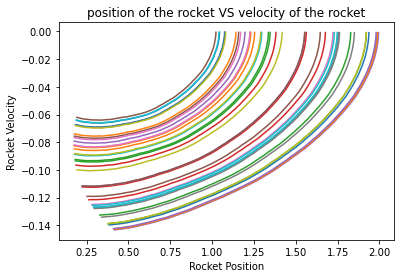

In [153]:
T = 200 # time steps
dim_input = 2  # state space dimensions
dim_hidden = 6  # latent dimensions
dim_output = 1  # action space dimensions
low_b_noise, up_b_noise = (-1e-3, 1e-3)
d = Dynamics()  # define dynamics
c = Controller(dim_input, dim_hidden, dim_output)  # control input, created by neural networks
s = Simulation(c, d, T,  low_b_noise, up_b_noise)  #simulation define the controller,dynamics,time steps and noise boundary 
o = Optimize(s)  # optimizer
o.train(40)

## state vector with 4 variable
Next, we want to see the state of the rocket when there is horizontal thrust acting on it.(instead of the just thrust vertically, but also thrust horizontally). We set the state variabe to have 4 elements, namely position and velocity in y axis and position and velocity in x axis. 
And the final object is: 
- land the rocket at the center of the platform with x direction position and velocity equal to 0(the coordinate system is chosen in a way that the origin is at the center of the platform and consider about the 2D case.)
- the position and the velocity of the rocket at the y axis are both 0, which is the same criteria compared to the one above. 

In [146]:
import logging
import numpy as np
import torch as t
import torch.nn as nn
from torch import optim
import matplotlib.pyplot as plt

logger = logging.getLogger(__name__)

# environment parameters
PLATFORM_WIDTH = 0.25  # landing platform width
PLATFORM_HEIGHT = 0.06  # landing platform height
FRAME_TIME = 0.1  # time interval
GRAVITY_ACCEL = 0.12  # gravity constant
BOOST_ACCEL = 0.18  # thrust constant
DRAG_ACCEL = 0.003  # drag constant
SIDE_BOOST=0.03

class Controller(nn.Module):  ## no need to change the controller because the problem formulated here is quite easy to 
    ##solve

    def __init__(self, dim_input, dim_hidden, dim_output):
        """
        dim_input: # of system states
        dim_output: # of actions
        dim_hidden: 
        """
        super(Controller, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(dim_input, dim_hidden),
            nn.Tanh(),
            nn.Linear(dim_hidden, dim_output),
            nn.Sigmoid())

    def forward(self, state):
        action = self.network(state)
        return action

class Dynamics(nn.Module):

    def __init__(self):
        super(Dynamics, self).__init__()

    def forward(self, state, action,  low_b_noise, up_b_noise):
        """
        action: thrust or not thrust
        state[0] = y
        state[1] = y_dot
        state[2]=x
        state[3]=x_dot
        """
        # Apply gravity
        delta_state_gravity = t.tensor([0., GRAVITY_ACCEL * FRAME_TIME,0.,0.])

        # Thrust and drag
        delta_state_drag = (DRAG_ACCEL) * FRAME_TIME * t.tensor([0., 1.,0.,0.]) * action
        
        # thrust exerted on the side of the rocket
        delta_state_thrust = (- BOOST_ACCEL) * FRAME_TIME * t.tensor([0., 1.,0.,0.]) * action
        
        delta_state_side_thrust = (SIDE_BOOST) * FRAME_TIME * t.tensor([0., 0.,0.,1.]) * action

        noise_x = t.tensor([1, 0,0,0]) * t.tensor(np.random.uniform(low_b_noise, up_b_noise, 1))
        noise_v = t.tensor([0, 1,0,0]) * t.tensor(np.random.uniform(low_b_noise, up_b_noise, 1))
        noise = noise_x+noise_v

        # Update velocity
        state = state + delta_state_gravity + delta_state_drag+ delta_state_thrust+ delta_state_side_thrust

        # Update state
        step_mat = t.tensor([[1.,FRAME_TIME,0.0],
                             [0., 1.,0.,0.],[0.,0.,1.,FRAME_TIME],[0.,0.,0.,1.]]) ##step matrix for 
        ##state vector with 4 components
      
        state = t.matmul(state, step_mat) + noise.float()
      
        return state
    
class Simulation(nn.Module):

    def __init__(self, controller, dynamics, T,  low_b_noise, up_b_noise):
        super(Simulation, self).__init__()
        self.state = self.initialize_state()
        self.controller = controller
        self.dynamics = dynamics
        self.T = T
        self.action_trajectory = []
        self.state_trajectory = []
        self.low_b_noise = low_b_noise
        self.up_b_noise = up_b_noise

    def forward(self, state):
        self.action_trajectory = []
        self.state_trajectory = []
        for _ in range(T):
            action = self.controller(state)
            state = self.dynamics(state, action,  self.low_b_noise, self.up_b_noise)
            self.action_trajectory.append(action)
            self.state_trajectory.append(state)
        return self.error(state)

    @staticmethod
    def initialize_state():
        """"
        state=np.ones((30,2))
        for i in range(state.shape[0]):
            state[i][0] = 1
            state[i][1] = 0
            state[i][2]=np.random.uniform(-0.125, 0.125, 1)
            state[i][3]=0
        """
        state=[1.,0.,0.125,0.]
        return t.tensor(state, requires_grad=False).float()
        
    def error(self, state):
        return state[0]**2+state[1]**2,state[2]**2+state[3]**2

class Optimize:

    def __init__(self, simulation):
        self.simulation = simulation
        self.parameters = simulation.controller.parameters()
        self.optimizer = optim.LBFGS(self.parameters, lr=0.01)
        print()

    def step(self):
        def closure():
            loss = self.simulation(self.simulation.state)
            self.optimizer.zero_grad()
            loss.backward()
            return loss

        self.optimizer.step(closure)
        return closure()

    def train(self, epochs):
        for epoch in range(epochs):
            loss = self.step()
            print('[%d] loss: %.3f' % (epoch + 1, loss))
        self.visualize()

    def visualize(self):
        location_num=30
        data = np.array([self.simulation.state_trajectory[i].detach().numpy() for i in range(self.simulation.T)])
        x=data[:,0]
        y=data[:,1]
        plt.plot(x, y)
        plt.title('position and velocity of the rocket')
        plt.xlabel('Rocket Position')
        plt.ylabel('Rocket Velocity')
        plt.show()

In [147]:
T = 150 # time steps
dim_input = 4  # state space dimensions
dim_hidden = 6  # latent dimensions
dim_output = 1 # action space dimensions
low_b_noise, up_b_noise = (-1e-5, 1e-5)
d = Dynamics()  # define dynamics
c = Controller(dim_input, dim_hidden, dim_output)  # control input, created by neural networks
s = Simulation(c, d, T,  low_b_noise, up_b_noise)  #simulation define the controller,dynamics,time steps and noise boundary 
o = Optimize(s)  # optimizer
o.train(40)

ValueError: expected sequence of length 3 at dim 1 (got 4)